# Fractional delays and LFM

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

plt.rc('font', size=15)

In [107]:
#
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
def fftfilt(b, x, zi=None):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig = x.shape[0]
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros(L_sig+L_F, dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros(L_sig+L_F)

    FDir = fft_func(b, n=L_F)

    # overlap and add
    for n in offsets:
        res[n:n+L_F] += ifft_func(fft_func(x[n:n+L_S], n=L_F)*FDir)

    if zi is not None:
        res[:zi.shape[0]] = res[:zi.shape[0]] + zi
        return res[:L_sig], res[L_sig:]
    else:
        return res[:L_sig]
    

## Fractional delays

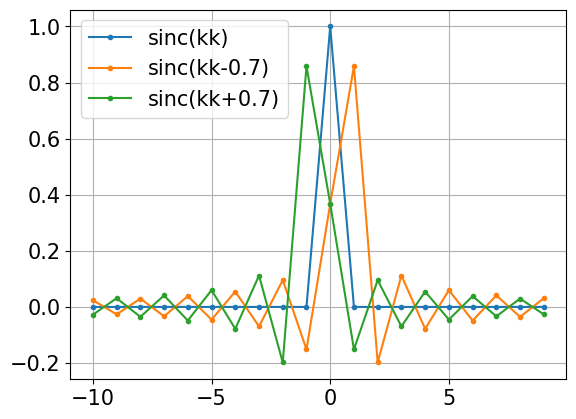

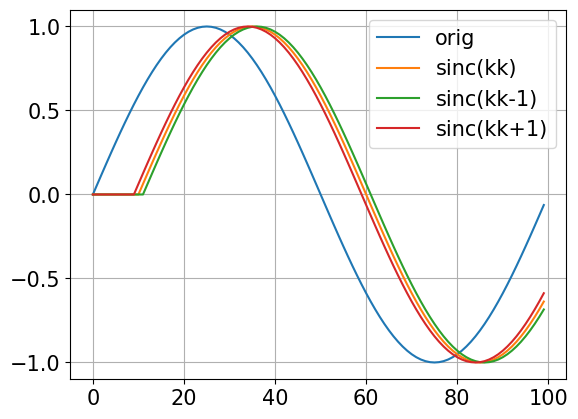

In [108]:
kk=np.arange(-10,10,1);
plt.plot(kk,np.sinc(kk),'.-')
plt.plot(kk,np.sinc(kk-0.7),'.-')
plt.plot(kk,np.sinc(kk+0.7),'.-')
plt.legend(("sinc(kk)","sinc(kk-0.7)","sinc(kk+0.7)"))
plt.grid(True)
plt.show();

tx=np.arange(0,1,1/100)
x=np.sin(2*np.pi*tx)

#y1=sig.lfilter(np.sinc(kk),1,x)
#y2=sig.lfilter(np.sinc(kk-1),1,x)
#y3=sig.lfilter(np.sinc(kk+1),1,x)
y1=fftfilt(np.sinc(kk),x)
y2=fftfilt(np.sinc(kk-1),x)
y3=fftfilt(np.sinc(kk+1),x)
plt.plot(x)
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.legend(("orig","sinc(kk)","sinc(kk-1)","sinc(kk+1)"))
plt.grid(True)
plt.show()

### comment
the use of a FIT filter shifts the filtered output by half the window length, so here by 10 samples. The `fftfilt` function terminates here such the the length of the filtered time series corresponds to the input vector.

## Linear Frequency modulation + matched filter

In [109]:
# Simulate LFM
fs=96000    # sampling frequency (Hz)
f1=0        # LFM start frequency (Hz)
f2=24000    # LFM stop frequency (Hz)
t2=5        # LFM duration (s)
no=4        # shift between signals (samples)

#
# simulate signal
tt=np.arange(0,t2,1/fs)
om=2*np.pi*(f1+(f2-f1)/(2*t2)*tt)
xx=np.sin(om*tt)
nd=np.shape(xx)[0]
ndh=int(nd/2)
rep=np.flipud(xx)/np.sqrt((nd/2*np.sum(xx**2)))
yy=np.random.normal(scale=0.1,size=(8*fs,2))
ty=np.arange(0,8,1/fs)

n1=fs
n2=n1+int(0.01*fs)


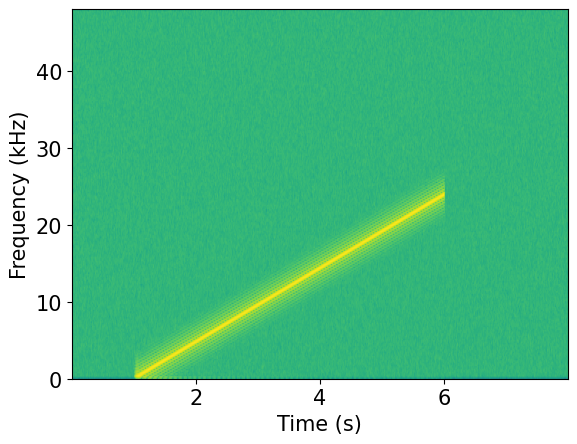

In [110]:
yy[n1:(n1+nd),0] += xx
yy[n1+no:(n1+no+nd),1] += xx

f,t,S1= sig.spectrogram(yy[:,0],fs=fs,nperseg=256,noverlap=128,nfft=512)
f,t,S2= sig.spectrogram(yy[:,1],fs=fs,nperseg=256,noverlap=128,nfft=512)

plt.imshow(10*np.log10(S1),origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show();


(5.999, 6.001)

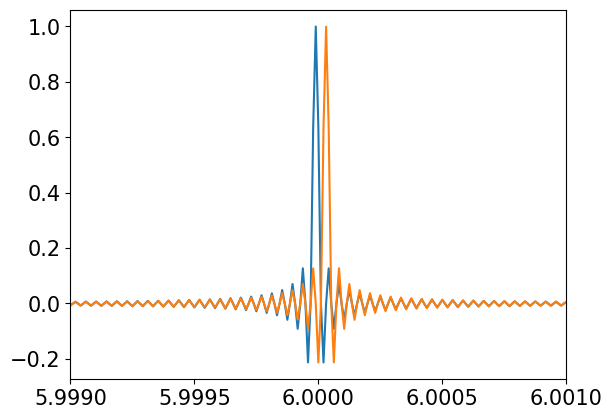

In [111]:
zz=0*yy
zz[:,0]=fftfilt(rep,yy[:,0])
zz[:,1]=fftfilt(rep,yy[:,1])
plt.plot(ty,zz,'-');
plt.xlim(5.999,6.001)


### comment
The matched filter output results in a sinc function

576001


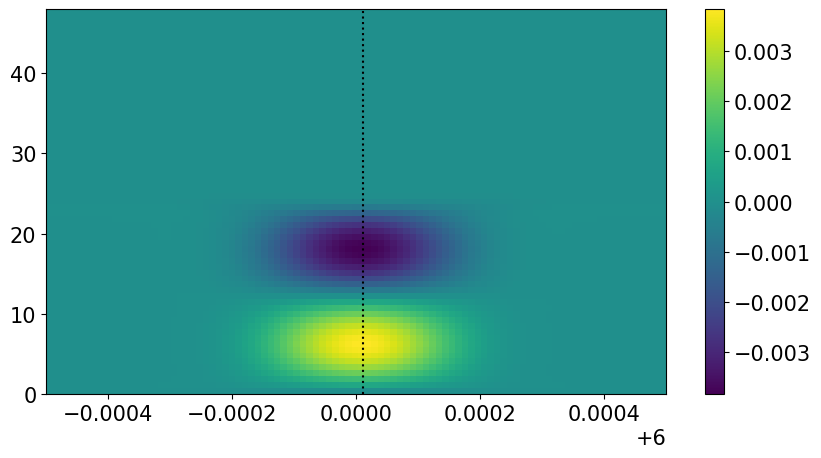

In [112]:
nw=64
nover=nw-1
nfft=2*nw
f,t,Q1= sig.stft(zz[:,0],fs=fs,nperseg=nw,noverlap=nover,nfft=nfft,window='hann')
f,t,Q2= sig.stft(zz[:,1],fs=fs,nperseg=nw,noverlap=nover,nfft=nfft,window='hann')

I=np.imag(Q1*np.conjugate(Q2))

m=np.where(I==np.max(I))
ix=m[1][0]
print(ix)

fig = plt.figure("figsize",[10,5])
plt.imshow(I,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.colorbar()
plt.xlim(6-0.0005,6+0.0005)

plt.plot(t[ix]+0*f,f/1000,'k:')
plt.show();

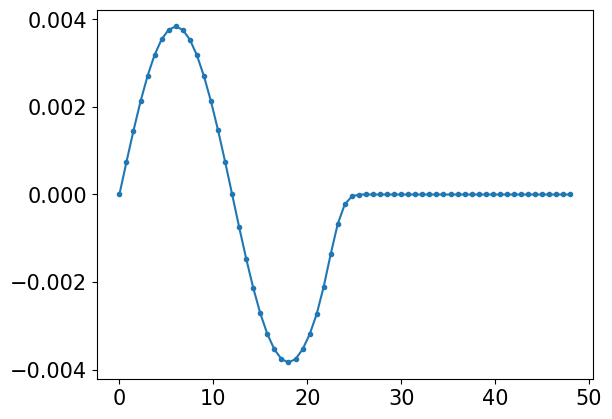

In [113]:

plt.plot(f/1000,I[:,ix],'.-')
plt.show();